In [1]:
using GLM
using DataFrames
using Random
using Parquet
import YAML
using Plots
using CSV
using StatsBase


include(raw"C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\glm\glm_utils.jl")

   ╭──── Function: predict ─────────────────────────────────────────────╮
   │                                                                    │
   │            (1)  predict(model::FittedModel, x::Matrix)             │
   │            (2)  predict(model::FittedModel, data::Union)           │
   │                                                                    │
   ╰────────────────────────────────────────────────────── 2 methods ───╯
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Docstring ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   No documentation found.                                                          
                                                                                    
   `predict` is a `Function`.                                                       
                                                                                    
       ┌───────────────────────────────────────────────────────────────────────────┐
       │  # 2 methods for generic function "predict":    

## Load GLM results
Load metadata of which cells were ran and their correlations

In [2]:
fitted = filter(kv -> kv.second["glm_fitted"], metadata)
@info "Fitted $(length(fitted))/$(length(metadata)) units"

formulas = generate_formulas()

for (k,v) in fitted
    # get the pearson correlations
    v["correlations"] = DataFrame(CSV.File(
        joinpath(v["folder"], "correlations.csv")
    ))

    # get the correlations of the shuffled data
    v["shuffled_correlations"] = DataFrame(CSV.File(
        joinpath(v["folder"], "shuffled_correlations.csv")
    ))

    # get a `FittedModel`
    try
        v["model"] = load_fitted(v, "complete", formulas)
    catch
        v["model"] = nothing
    end
end

nomodel = filter(kv -> isnothing(kv.second["model"]), fitted) |> keys |> collect
length(nomodel) > 0 && @info "No model fitted for $(length(nomodel)) units - revise metadata";

@Info (Main):  Fitted 146/146 units 
  ╰──────────────────────────────────────────────── 
                      Fri, 17 Jun 2022 17:00:28 


## Identify tuned
Look for units whose pearson correlation in the full mode is above the 99th CI of the shuffled correlations

In [25]:
for (k, unit) in fitted
    cbest = mean(unit["correlations"][:, "complete"])
    cshuff = mean.(eachcol(unit["shuffled_correlations"]))
    threshold = percentile(cshuff, 99) 

    unit["correlation_threshold"]  = threshold
    unit["tuned"] = cbest > threshold
end

tuned = filter(kv -> kv.second["tuned"], fitted)
@info "Tuned $(length(tuned))/$(length(fitted)) units"

@Info (Main):  Tuned 101/146 units 
  ╰──────────────────────────────────────────────── 
                      Fri, 17 Jun 2022 17:04:34 


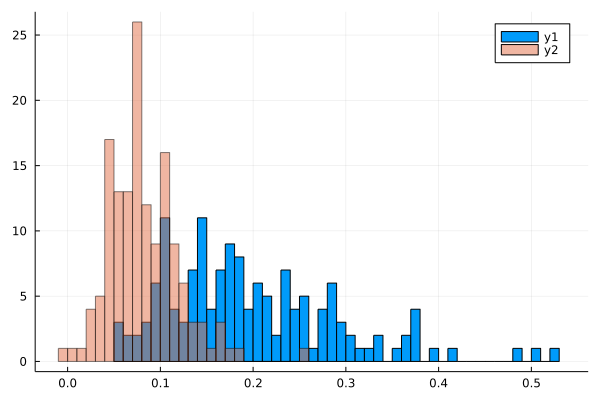

In [15]:
all_correlations = map(v -> v["best_corr"], values(fitted))
thresholds = map(v -> v["correlation_threshold"], values(fitted))
histogram(all_correlations; bins=50)
histogram!(thresholds; bins=25, alpha=.5)


# cbest = mean(unit["correlations"][:, "complete"])
# cshuff = mean.(eachcol(unit["shuffled_correlations"]))

# threshold = percentile(cshuff, 99)

# plot()
# histogram!(cshuff; bins=100)
# plot!([threshold, threshold], [0, 100], label="threshold")
# plot!([cbest, cbest], [0, 100], label="model corr")

In [6]:
# TODO to get the original variable scales, load min/max of original dataframes and:   # x_reconstructed = y * (X_max - _min) + _min
# TODO go from p(spike) to firing rate

In [7]:
# best = findfirst(all_correlations .> .15)
# @info best
# unit = collect(values(fitted))[best]

unit = collect(values(tuned))[50]

x = load_data(unit["model"])
ŷ = predict(unit["model"], x)
y = x.p_spike;

t0 = 40_000
t1 = t0 + 4_000

time = collect(0:(t1-t0)) / 200  # time in seconds

plot(ylabel="firing rate (norm.)", xlabel="time")
plot!(time,  y[t0:t1], fillrange =0, fillcolor=:black, fillalpha=.2, color="black", lebel="data", alpha=.5, lw=2)
plot!(time,  ŷ[t0:t1], lw=3, label="prediction")
plot!(time, x.v[t0:t1], lw=3, label="speed", fillrange =0, fillcolor=:green, fillalpha=.2)

UndefVarError: UndefVarError: tuned not defined